# Solving the Navigation Project with a Double Deep Q-Network (DDQN)
---
In this notebook, we train a DDQN agent to solve the navigation project within the Udacity Deep Reinforcement
Learning Nanodegree.

### 1. Import the Necessary Packages

In [1]:
from collections import deque

import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from unityagents import UnityEnvironment

from p1_navigation.ddqn_agent import Agent as DDQN_Agent

### 2. Instantiate the Environment

Initialize the environment in the code cell below. **Change the unity environment path if necessary!**

In [2]:
# change path if necessary
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space
state = env_info.vector_observations[0]
state_size = len(state)
print('States have length:', state_size)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of actions: 4
States have length: 37


### 3. Instantiate and Train the DDQN Agent

Run the code cell below to instantiate and train the DDQN Agent

In [3]:
def train_agent(agent, n_episodes=2000, max_t=2000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        agent.adaptive_eps.update()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), './checkpoints/checkpoint_' + str(i_episode-100) +  '.pth')
            break
    return scores

agent = DDQN_Agent(state_size=state_size, action_size=action_size)
scores = train_agent(agent)

Episode 100	Average Score: 0.25
Episode 200	Average Score: 0.58
Episode 300	Average Score: 1.63
Episode 400	Average Score: 3.28
Episode 500	Average Score: 4.28
Episode 600	Average Score: 6.38
Episode 700	Average Score: 7.35
Episode 800	Average Score: 8.46
Episode 900	Average Score: 10.55
Episode 988	Average Score: 13.07
Environment solved in 888 episodes!	Average Score: 13.07


### 4. Plot the training scores

We plot the training scores and a running average over 100 episodes in the next cell.

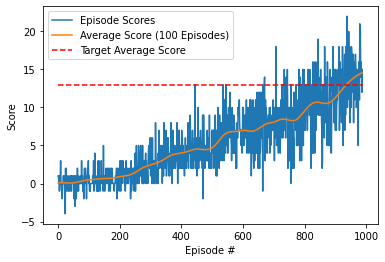

In [8]:
# compute running average score across 'win_size' episodes
win_size = 100
win = ss.windows.hann(win_size)
win /= np.sum(win)
padded_scores = np.append(scores, [scores[-1]]*(win_size-1))
smoothed_scores = ss.convolve(padded_scores, win, mode='same')[:len(scores)]

# plot the scores
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Episode Scores')
plt.plot(np.arange(len(smoothed_scores)), smoothed_scores, label='Average Score (100 Episodes)')
plt.plot([0, len(scores)], [13, 13], '--r', label='Target Average Score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='best')
# plt.show()

plt.savefig('./img/scores.png', dpi=400)


### 5. Watch a Smart Agent collecting Blue Bananas!

Load the trained weights from a file and watch the trained agent perform its task! **Adapt the checkpoint file *.pth
if necessary!**

In [12]:
# load the weights from file
agent = DDQN_Agent(state_size=state_size, action_size=action_size)
agent.qnetwork_local.load_state_dict(torch.load('./checkpoints/checkpoint_888.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
for t in range(1000):
    action = agent.act(state, greedy=True)         # select an action greedily
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))


Score: 15.0


### 5. Close the Environment

Close the environment if training and evaluation are finished.

In [13]:

env.close()